# 2. Введение в машинное обучение

In [1]:
import pandas as pd
import random
from IPython.display import Image
from setup import *
plt.rcParams['font.size'] = 12

%load_ext autoreload

%autoreload 2

# 2.1 Постановка задачи
## Дано

* $\mathbb{X}$ - пространство `объектов` (`features`)<br>
* $\mathbb{Y}$ - пространство `ответов` (`targets`)<br>
* $\{(x_1,y_1), (x_2,y_2) ... (x_n,y_n)\}$ - выборка данных $x_i$ и соответствующих им ответов $y_i$<br> также её обозначают через $X = \{x_1, x_2 ... x_n\}$ и $Y = \{y_1, y_2 ... y_n\}$<br>
* $\mathcal{F}: \mathbb{X} \rightarrow \mathbb{Y}$ - неизвестная зависимость (target function)

## Хотим найти 
В идеале истиную зависимость: $\mathcal{F}$

Но в реальности будем искать

$a: \mathbb{X} \to \mathbb{Y}$ - **алгоритм**, `приближающий` $a(x_i)$ к $y_i$.

## Что значит приближать?

Пусть $Q(a, X, Y)$ - **функционал ошибки**

Нужно найти такое $a$, которое минимизирует $Q(a,X, Y)$. Иначе говоря

$$a = argmin_{a \in \mathbb{A}}Q(a, X, Y)$$

где $\mathbb{A}$ - `набор алгоритмов`.


## Пример
* $\mathbb{X} = \mathbb{R}$
* $\mathbb{Y} = \mathbb{R}$
* $\mathbb{A}$ - полиномы степени 1. (Линейная регрессия: $a(x) = w_0x + w_1$)
* $X = \{1, 2\}$
* $Y = \{1, 2\}$
* $Q(a,X,Y) = \sum_{i=1}^{n}(a(x_i) - y_i)^2$ 

Мы хотим найти такое $a \in \mathbb{A}$, чтобы сумма квадратов отклонений от реальных ответов была минимальной. 

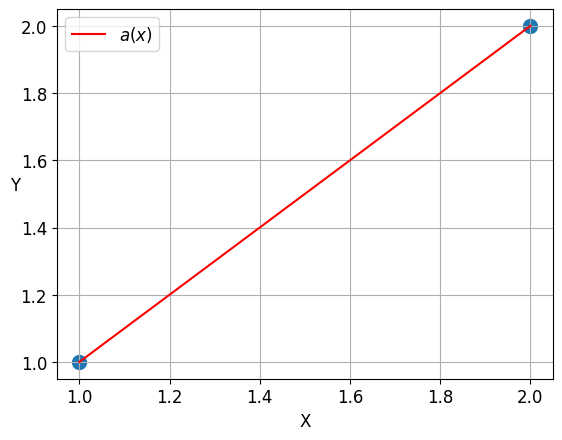

In [2]:
X = np.array([[1], [2]])
y = np.array([1, 2])
ax = plt.gca()
ax.scatter(X, y, s=100)
ax.plot(X, y, c="red", label="$a(x)$")
ax.set_xlabel('X')
ax.set_ylabel('Y', rotation=0)
ax.legend()
ax.grid()
plt.show()

Очевидный и точный ответ $a(x) = x$. Он минимизирует $Q(a,X,Y)$ до $0$.

Однако если добавим в выборку точку $(3, 4)$, то ответ будет другим и функционал не будет достигать $0$ ни при каком алгоритме из выбранного множества.

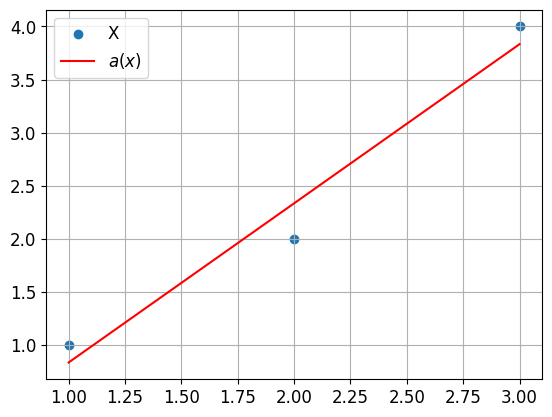

In [3]:
from sklearn.linear_model import LinearRegression

X = np.array([[1], [2], [3]])
y = np.array([1, 2, 4])
model = LinearRegression().fit(X, y)
ax = model.predict(X)
plt.scatter(X, y, label="X")
plt.plot(X, ax, c="red", label="$a(x)$")
plt.legend()
plt.grid()


## Вопросы
* Какое множество $\mathbb{A}$ можно выбрать, чтобы функционал из примера выше мог достичь $0$?
* Имеет ли смысл алгоритм $a(x) = 0$?
* Имеет ли смысл функционал $Q(a) = 0$?
* Почему берем $Q(a,X,Y) = \sum_{i=1}^{n}(a(x_i) - y_i)^2$? Можно ли взять модуль?

## Итог

В задаче МО нужно выбрать разумные $\mathbb{A}$ и $Q(a,X, Y)$, а потом найти наилучший $a$, решающий задачу в этих условиях.

Творческий процесс МО происходит именно здесь: нам нужно как-то интерпретировать фразу `"хорошо решать задачу"` в терминах $\mathbb{A}$ и $Q(a, X, Y)$.

Далее следует техническая часть нахождения $a \in \mathbb{A}$. Которая и называется `обучением`

**Вопрос:** как описать задачу по разделению фотографий котиков и собак?

# 2.2 Формат данных

### Что такое объект из $\mathbb{X}$?

Пусть объект $x_i$ - это набор признаков $(f_1^i,\ldots, f_m^i)$

Что такое признаки (features)? Некие простые значения.

Обычно признаки делят на типы, например: 
- `Бинарные`: $\{0, 1\}$
- `Количественные`: $f(x) \in \mathbb{Q}, \mathbb{R}, \mathbb{C}$
- `Категориальные`: *{ Пол, Город, Страна, Персонаж в Dota2 и т.д. }*
- `Порядковые`: *{ Уровень образования(Бакалавр, Магистр,...), Ранг в CSGO и т.д. }*


In [4]:
data = pd.DataFrame(
    {
        "numeric": np.arange(0, 1, 0.3),
        "binary": np.arange(0, 1, 0.3) > 0.4,
        "category": np.array(["dog", "cat", "parrot", "shark"]),
        "ordinal": np.array(["bachelor", "magister", "assistant", "doctor"]),
    }
)


In [5]:
data


,numeric,binary,category,ordinal
0,0.0,False,dog,bachelor
1,0.3,False,cat,magister
2,0.6,True,parrot,assistant
3,0.9,True,shark,doctor


### Что такое ответ из $\mathbb{Y}$?

Тоже признак или набор признаков. Но пока будем говорить только об одном признаке.

In [6]:
data["numeric"]


0    0.0
1    0.3
2    0.6
3    0.9
Name: numeric, dtype: float64

# 2.3 Задачи МО и алгоритмы

В основе, есть две задачи МО
* **Классификация** ($\mathbb{Y}$ - конечное)
* **Регрессия** ($\mathbb{Y}$ - бесконечное)


Для упрощения далее мы будем рассматривать пример **2-х классовой классификации**($|\mathbb{Y}|=2$) и **регрессии на $\mathbb{R}$** ($\mathbb{Y} = \mathbb{R}$)

## Генерация выборок
### Классификация
Сгенерируем выборку для 2 классов. 

In [7]:
np.random.seed(1337) 
n = 200
a = np.random.normal(loc=0, scale=1, size=(n, 2))  # первый класс
b = np.random.normal(loc=3, scale=2, size=(n, 2))  # второй класс
X_clf = np.vstack([a, b])  # двумерный количественный признак
y_clf = np.hstack([np.zeros(n), np.ones(n)])  # бинарный признак


(400, 2) (400,)


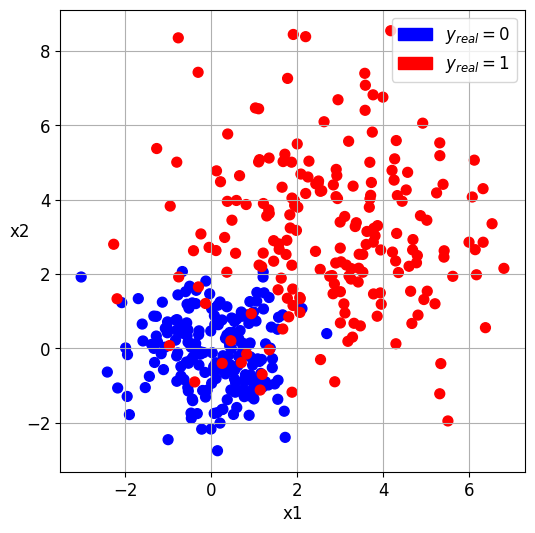

In [8]:
print(X_clf.shape, y_clf.shape)
plt.figure(figsize=(6, 6))
plt.scatter(X_clf[:, 0], X_clf[:, 1], c=y_clf, cmap="bwr", s=50, alpha=1)
plt.xlabel("x1")
plt.ylabel("x2", rotation=0)
blue_patch = mpatches.Patch(color="blue", label="$y_{real}=0$")
red_patch = mpatches.Patch(color="red", label="$y_{real}=1$")
plt.legend(handles=[blue_patch, red_patch])
plt.grid()


### Регрессия
Создадим функцию $\mathcal{F}(x) = \sqrt{x} + sin(x)$. Накинем на неё немного случайного шума: реальные данные никогда не идеальны. Датчики измеряют с погрешностью и иногда сходят с ума, люди путают количество нолей, в памяти компьютеров случаются bit flip'ы ([правда случаются](https://web.archive.org/web/20120113151522/https://status.aws.amazon.com/s3-20080720.html)). В общем, данные всегда следует считать зашумленными, без вариантов.

In [9]:
def f(x):
    return np.sqrt(x) + np.sin(x)


vf = np.vectorize(f)
rng = np.random.RandomState(1)

X_reg = np.arange(0, 10, 0.2)[:, np.newaxis]
y_reg = vf(X_reg) + (rng.rand(50)[:, np.newaxis] / 3)  # добавляем шумы


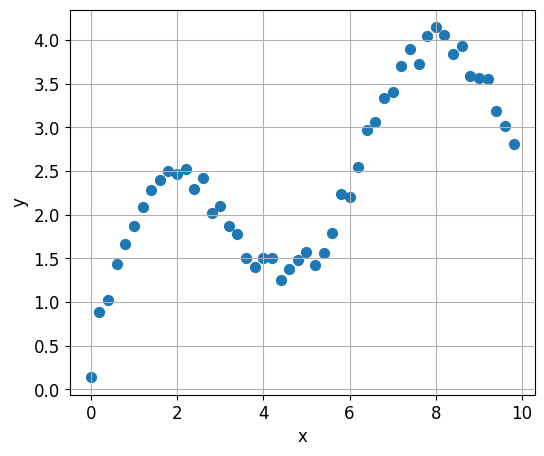

In [10]:
plt.figure(figsize=(6, 5))
plt.scatter(X_reg, y_reg, cmap="bwr", s=50, alpha=1)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()


# Обучение!

Сейчас будем перебирать разные ~~черные ящики~~ `пространства алгоритмов` $\mathbb{A}$, чтобы решить задачу классификации. 

Мы нигде не будем углубляться во внутреннее устройство каждого из алгоритмов. Об этом мы поговорим на след. семинарах. 
В это нам поможет [scikit-learn или просто sklearn](https://scikit-learn.org/stable/index.html) 
библиотека, в которой реализованы стандартные алгоритмы машинного обучения. 

## [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier)
Основная идея: 
* сохраняет в себе все точки выборки
* когда хотим предсказать следующую точку, ищем k ближайших точек (по умолчанию точек 5, а метрика расстояния - эвклидова)
* из какого класса точек среди ближайших больше - тот класс и присваивается новой точке.

### 1.Импортируем классификатор

In [11]:
from sklearn.neighbors import KNeighborsClassifier as KNN


### 2.Обучаем

In [12]:
clf_knn = KNN(n_neighbors=4)  # получаем экземпляр модели A
clf_knn.fit(X_clf, y_clf)  # обучаем модель на данных a


KNeighborsClassifier(n_neighbors=4)

### 3.Предсказываем результат

In [13]:
clf_knn.predict(np.array([[2, 0], [0, 2]]))


array([0., 0.])

### 4.Предсказываем вероятности попадания в класс (не всегда доступен этот метод)

In [14]:
clf_knn.predict_proba(np.array([[2, 0], [0, 2]]))


array([[0.5, 0.5],
       [0.5, 0.5]])

### 5.Предскажем результат для всей плоскости

KNeighborsClassifier(n_neighbors=4)

<Figure size 700x700 with 0 Axes>

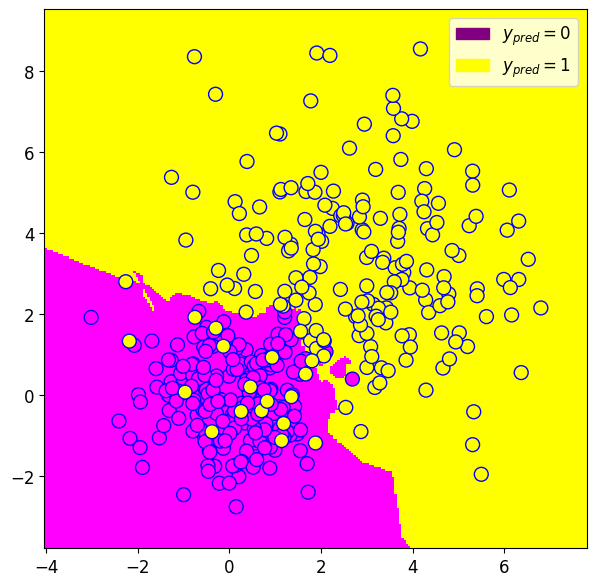

In [15]:
plt.figure(figsize=(7, 7))
plot_model(X_clf, y_clf, clf_knn, proba=False)


Алгоритм классификации объекта:
 - Вычислить расстояние до каждого из объектов обучающей выборки
 - Отобрать $k$ объектов обучающей выборки, расстояние до которых минимально
 - Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей
 

Ленивость - вычисления начинаются только в момент классификации тестового примера.

Скорость - при большом количестве объектов в тесте, алгоритм будет долго работать для **каждого** предсказания.

**Вопрос:** А как можно ускорить процесс классификации через KNN?

По факту здесь **не происходит обучения** в обычном его понимании: мы просто загружаем все данные в память, не проделывая над ними какой-то явной работы для получения хорошо работающего алгоритма.

## [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Строит гиперплоскость (в случае размерности 2 - прямую) $a(x) = w_0 + w_1x_1 + \ldots + w_nx_n$, которая с наименьшей `ошибкой` **приближается** к точкам.

$Q(a, X, Y) = \sum_{i=1}^{n}(a(x_i) - y_i)^2 \to min$

Как найти $w_1$ и $w_0$?

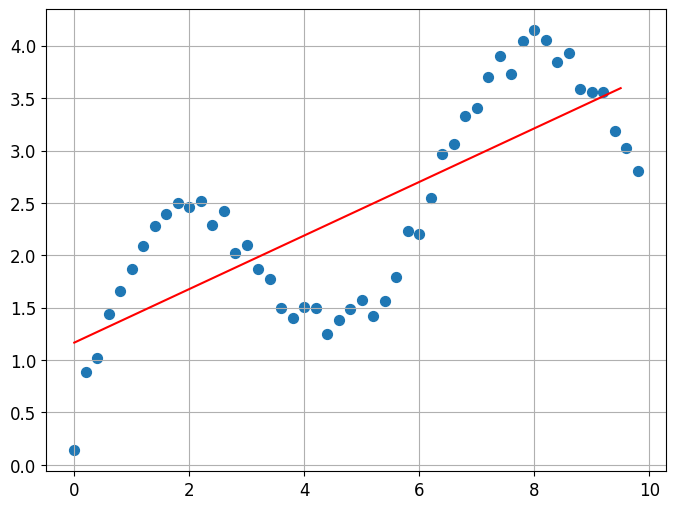

In [16]:
from sklearn.linear_model import LinearRegression as LR

reg_lr = LR()  # A
X_reg_test = np.arange(0, 10, 0.5)[:,np.newaxis]
plot_reg(X_reg, y_reg, reg_lr, X_reg_test)


Что-то так себе:) Но на самом деле логично. Линейная регрессия - пространство алгоримов полиномов 1 степени. ($w_0x + w_1$). 

* **Вопрос:** Как мы можем улучшить данный алгорим?
* **Вопрос:** Как мы можем улучшить результат данного алгорима не меняя $\mathbb{A}$?  

### А можно ли использовать линейную регрессию для классификации и соседей для регрессии?

Ага. Линейная модель позволяет строить гиперплоскость (в случае размерности 2 - прямую) $a(x) = w_0 + w_1x_1 + \ldots + w_nx_n$, которая с наименьшей `ошибкой` разделяет классы. Исторически примененияе этого алгоритма к задаче классификации называется логистической *регрессией*, хотя по факту решается таки задача классификации. Из-за этой путаницы на собесах джунов\стажёров любят вопросы вида "какую задачу решает алгоритм логистической регрессии"?

Что означает слово "логистическая" станет понятно на следующем занятии.

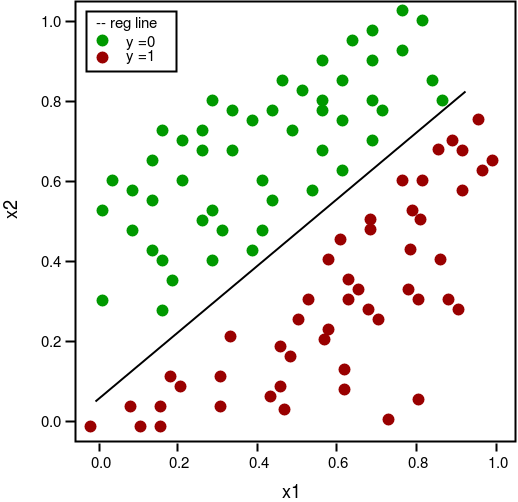

In [17]:
Image("images/logreg.png")


LogisticRegression(solver='newton-cg')

<Figure size 700x700 with 0 Axes>

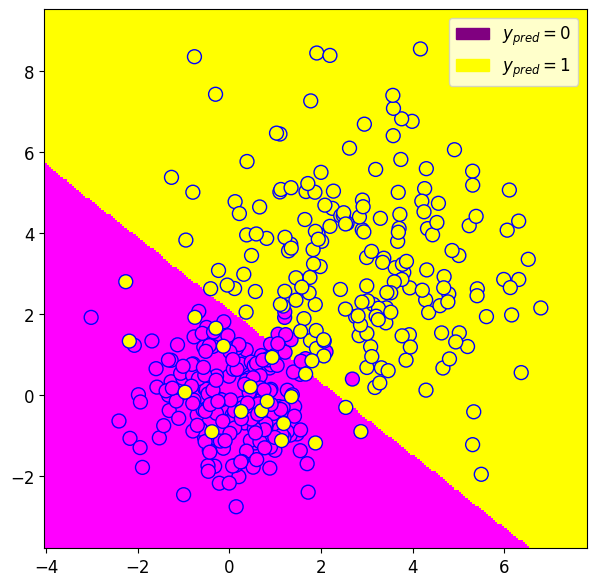

In [18]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="newton-cg").fit(X_clf, y_clf)
plt.figure(figsize=(7, 7))
plot_model(X_clf, y_clf, log_reg)


## [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

Идея: находим k ближайших соседей к новой точке и берем их **средние** координаты.

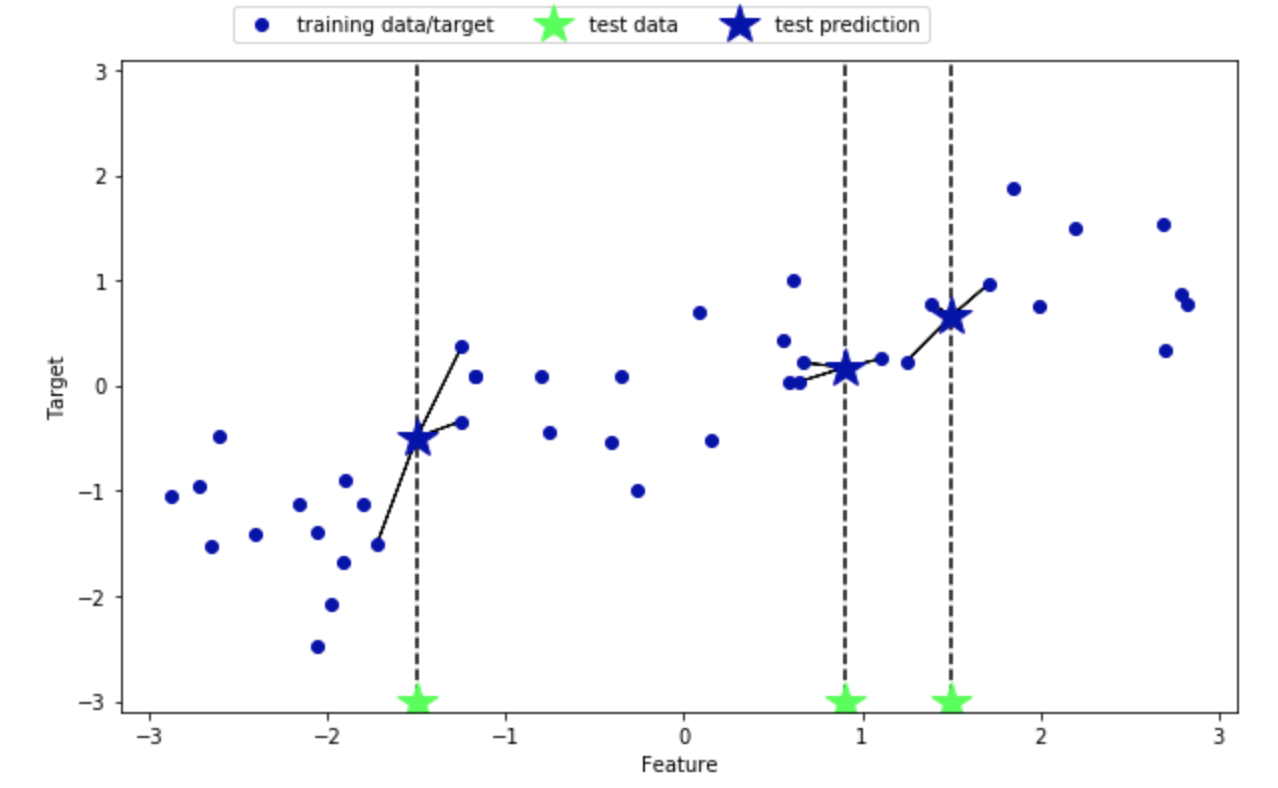

In [19]:
Image("images/knnreg.png",width=700)

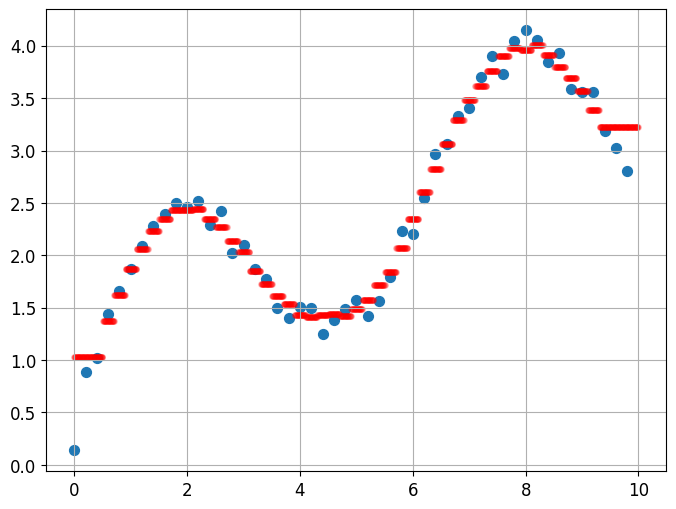

In [20]:
from sklearn.neighbors import KNeighborsRegressor as KNR

clf_knd = KNR(n_neighbors=5)
X_test = np.arange(0, 10, 0.01)[:, np.newaxis]
plot_reg(X_reg, y_reg, clf_knd, X_test, kind='scatter')


### И конечно есть ещё много других алгоритмов, например **дерево решений**

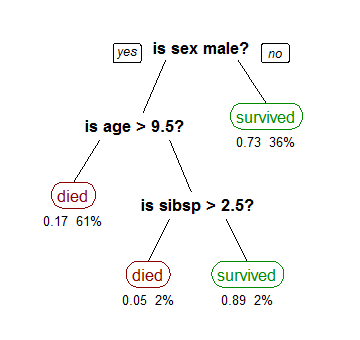

In [21]:
Image("images/treeexample.png")


DecisionTreeClassifier(max_depth=3)

<Figure size 700x700 with 0 Axes>

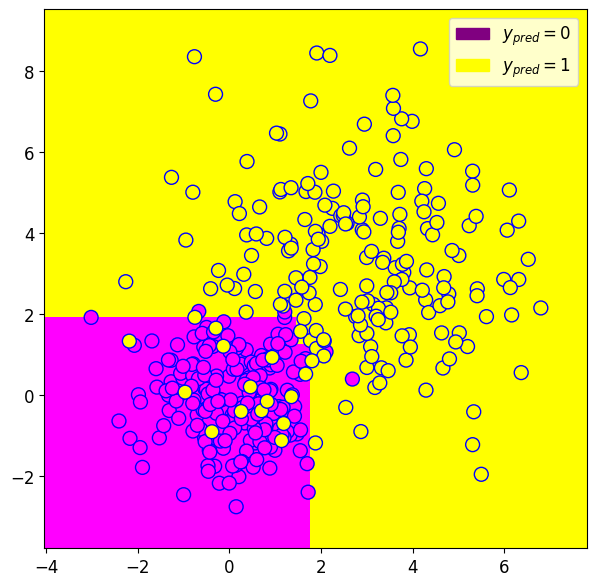

In [22]:
from sklearn.tree import DecisionTreeClassifier as DTC

clf_dtc = DTC(max_depth=3).fit(X_clf, y_clf)
plt.figure(figsize=(7, 7))
plot_model(X_clf, y_clf, clf_dtc)


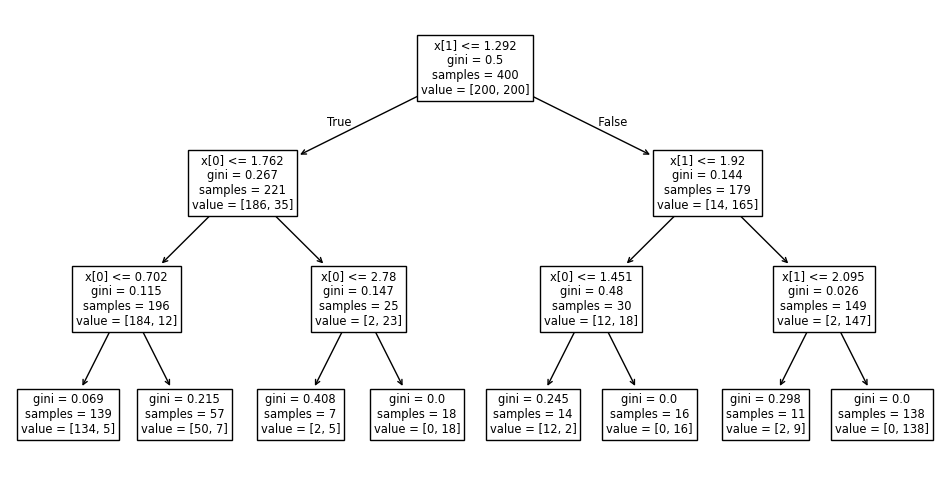

In [23]:
import sklearn
plt.figure(figsize=(12,6))
img = sklearn.tree.plot_tree(clf_dtc)

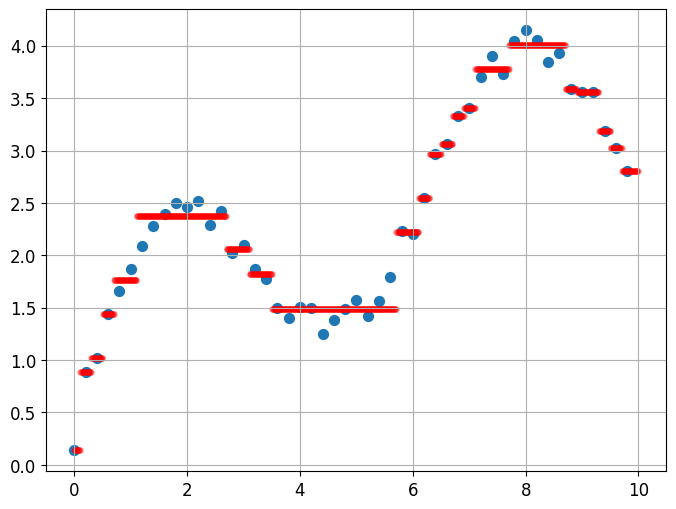

In [24]:
from sklearn.tree import DecisionTreeRegressor as DTR

clf_knd = DTR(max_depth=5)
X_test = np.arange(0, 10, 0.01)[:, np.newaxis]
plot_reg(X_reg, y_reg, clf_knd, X_test, kind='scatter')


# 2.4 Гиперпараметры и параметры

Как мы можем влиять на пространство алгоритмов? 

Например уменьшить его, чтобы задача решалась быстрее или совсем поменять, чтобы найти новые решения?

* **Гиперпараметры** - свойства семейства алгоритмов, в котором мы ищем алгоритм. **Не изменяются** на протяжении `обучения`.
* **Параметры** - внутренние параметры алгоритма, **изменение** которых и есть процесс `обучения`.

Например: 
* гиперпараметр - это, например, степень полинома, который мы строим в задаче регрессии или функционал минимизации.
* параметр - коэффициенты полинома в линейной регрессии, которые мы алгоритмически подбираются по нашим данным.

### Параметры зависят от выборки

[[0.25563732]] [1.16652522]


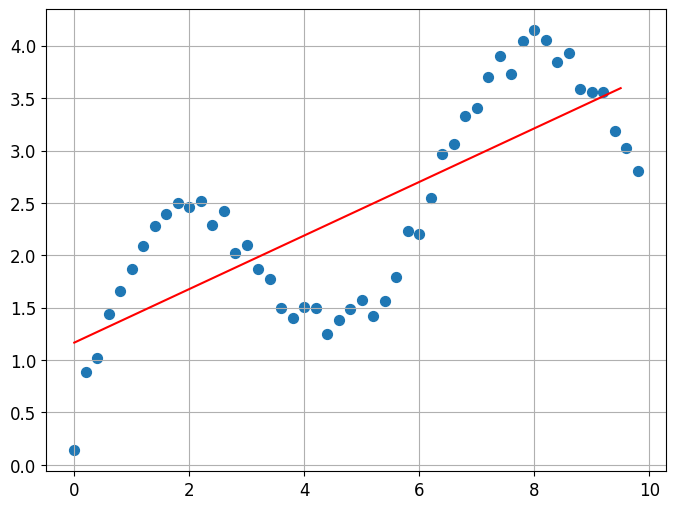

In [25]:
from sklearn.linear_model import LinearRegression as LR

new_y_reg = y_reg

reg_lr = LR().fit(X_reg, new_y_reg)

print(reg_lr.coef_, reg_lr.intercept_)

X_test = np.arange(0, 10, 0.5)[:, np.newaxis]
plot_reg(X_reg, new_y_reg, reg_lr, X_test)


### Гипрепараметры зависит от нас

KNeighborsClassifier(n_neighbors=7)

<Figure size 700x700 with 0 Axes>

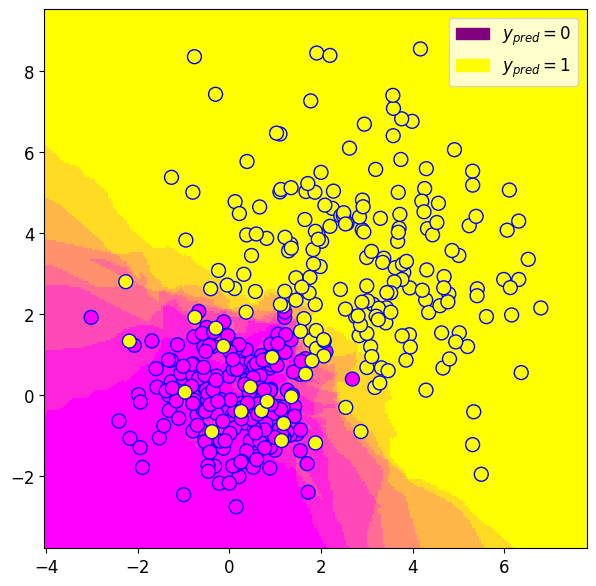

In [26]:
clf_knn = KNN(n_neighbors=7)  # получаем экземпляр модели
clf_knn.fit(X_clf, y_clf)  # обучаем модель на данных
plt.figure(figsize=(7, 7))
plot_model(X_clf, y_clf, clf_knn, proba=True)


KNeighborsClassifier(n_neighbors=2)

<Figure size 700x700 with 0 Axes>

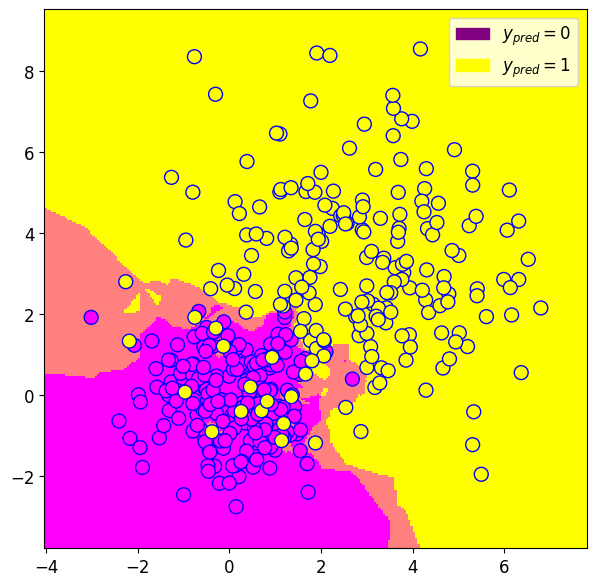

In [27]:
clf_knn = KNN(n_neighbors=2)  # получаем экземпляр модели
clf_knn.fit(X_clf, y_clf)  # обучаем модель на данных
plt.figure(figsize=(7, 7))
plot_model(X_clf, y_clf, clf_knn, proba=True)


## А где же функционал?

Заметим, что мы пока нигде не перебираем $Q(a,X, Y)$. Хотя можем.

На следующем примере мы выберем 2 функционала, по которым строятся правила дерева решений. Пока не вдаемся в то, как они это делают. Главное - мы сами передаем функционал как параметр в модель. 

In [28]:
from sklearn.tree import DecisionTreeRegressor as DTR

reg_dtr_mse = DTR(criterion="squared_error", max_depth=3)  # default
reg_dtr_mae = DTR(criterion="absolute_error", max_depth=3)


$$MSE(a,X, Y) = \frac{1}{n}\sum_{i=1}^{n}(a(x_i) - y_i)^2$$
$$MAE(a,X, Y) = \frac{1}{n}\sum_{i=1}^{n}|a(x_i) - y_i|$$

Случайный датасет для задачу регрессии или классификации можно сгенерировать средствами sklearn

In [29]:
from sklearn.datasets import make_regression

X_f, y_f = make_regression(n_samples=200, n_features=1, n_targets=1, noise=10, random_state=1234)


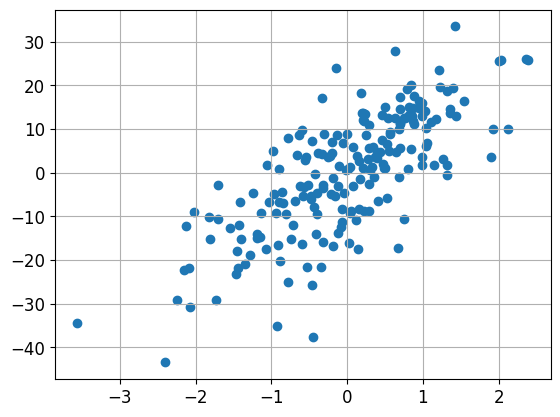

In [30]:
plt.scatter(X_f, y_f)
plt.grid()


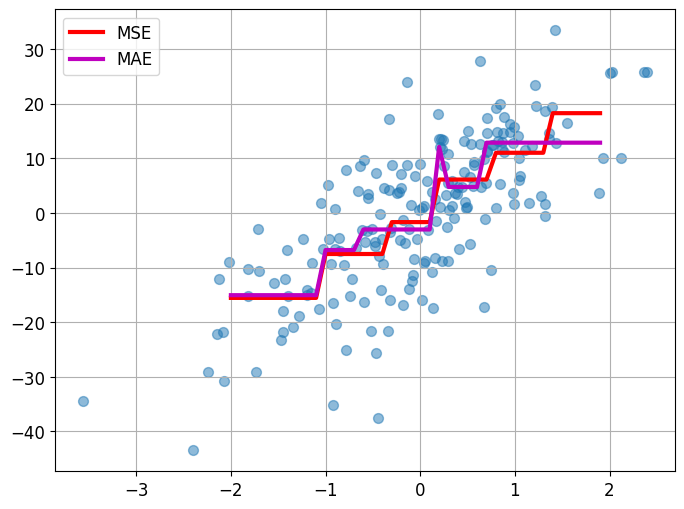

In [31]:
X_f_test = np.arange(-2, 2, 0.1)[:, np.newaxis]

reg_dtr_mse.fit(X_f, y_f)
Y_f_mse = reg_dtr_mse.predict(X_f_test)

reg_dtr_mae.fit(X_f, y_f)
Y_f_mae = reg_dtr_mae.predict(X_f_test)


plt.figure(figsize=(8, 6))
plt.scatter(X_f, y_f, cmap="bwr", s=50, alpha=0.5)
plt.plot(X_f_test, Y_f_mse, "r", label="MSE", lw=3)
plt.plot(X_f_test, Y_f_mae, "m", label="MAE", lw=3)
plt.legend()
plt.grid()


Часто реализации алгоритмов уже знают, какой функционал ему обычно лучше минимизировать. Иногда мы можем сами его настраивать среди возможных вариантов.

# 2.5 Качество модели, переобучение.

DecisionTreeClassifier()

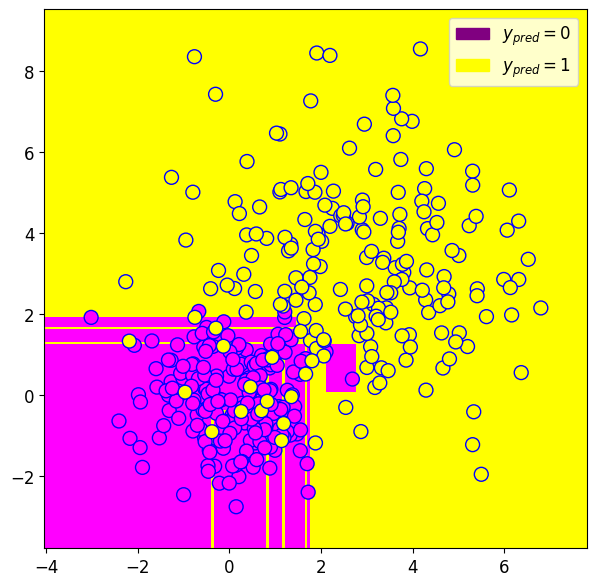

In [32]:
from sklearn.tree import DecisionTreeClassifier as DTC

clf_dtc = DTC().fit(X_clf, y_clf)
plot_model(X_clf, y_clf, clf_dtc)


Заметим, что данное разбиение слишком сильно опирается на тренировочную выборку: есть области желтого внутри фиолетового, что с большой вероятностью неверно. И новый тестовый объект будет некорректно классифицироваться из-за этого.

**Переобучение** может возникать в нескольких случаях:
 * Нерепрезентативность выборки в любом смысле: мало данных, или не все классы равнопредставлены или иной дефект. Тогда для алгоритм может обучиться не на общие закономерности в данных, а на какие-то частные взаимосвязи, которые верны для нашей выборки, но не верны в целом.
 * Если в выборке присутствует много `шума` или есть `выбросы`.

`Шум` - небольшие колебания данных, вызванные обычно неточностью приборов, ошибками людей и в целом невозможностью померить все `точно`. Можно считать, что любые данные идут с определенной долей шума.

`Выброс` - серьезное отклонение в данных вызванное ошибками в наблюдениях или естественными аномалиями в данных.

На рисунке сверху боковой квадрат сформировался из-за серьезного шума, который в данном случае сработал как выброс.


Чтобы избавиться от этого эффекта можно упростить модель, чтобы она могла уловить меньшее число зависимостей и из-за этого "смотрела" на самые "сильные" зависимости. Тут мы неявно предполагаем, что взаимосвязи, которые характерны для нашей частной выборки, а не для общей, меньше влияют на ответ, чем "настоящие" зависимости в нашей задаче.
Возьмем `max_depth=3`.

DecisionTreeClassifier(max_depth=3)

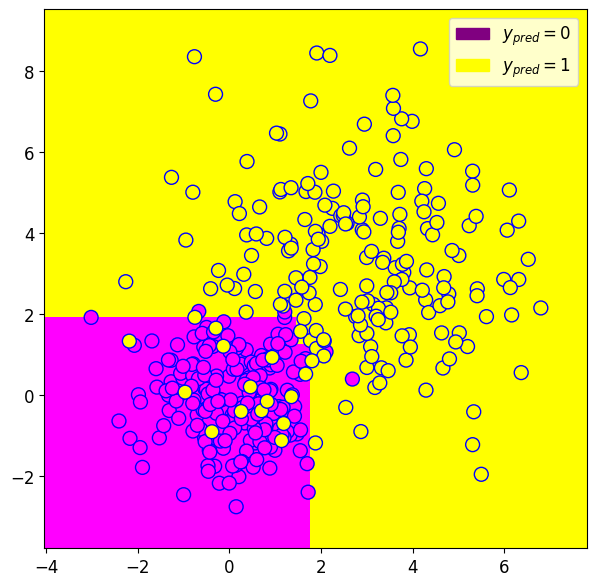

In [33]:
from sklearn.tree import DecisionTreeClassifier as DTC

clf_dtc = DTC(max_depth=3).fit(X_clf, y_clf)
plot_model(X_clf, y_clf, clf_dtc)


Мы получили неверные ответы для нескольких выбросов, зато получили более разумные суждения в целом. 

Однако нельзя сильно упрощать модель (`max_depth=1`), это может вызвать другую крайность, так как в нашем семействе алгоритмов может не оказаться вообще ничего похожего, на истиную зависимость

DecisionTreeClassifier(max_depth=1)

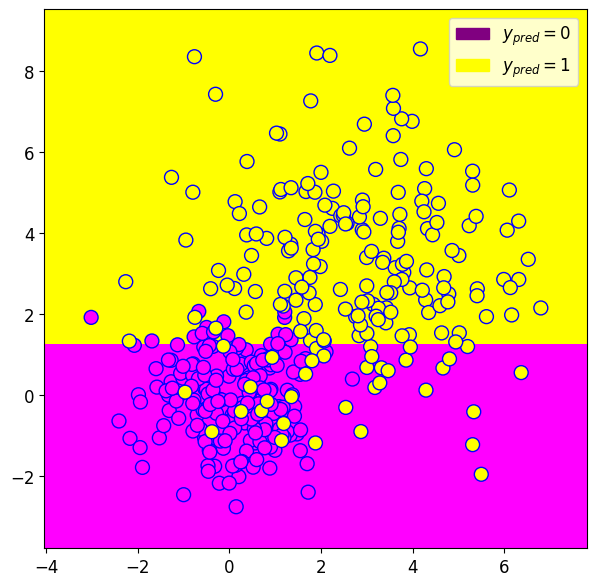

In [34]:
from sklearn.tree import DecisionTreeClassifier as DTC

clf_dtc = DTC(max_depth=1).fit(X_clf, y_clf)
plot_model(X_clf, y_clf, clf_dtc)


Для регресии такой эффект можно также увидеть на картинках.

![title](images/overfit_reg.png)

### Проблема: очень сложный алгоритм может слишком хорошо выучить выборку и давать некорректный результат на остальных данных

И хочется как минимум заметить, если такое случилось.

Чтобы заметить переобучение необходимо предварительно выборку разбить на Train и Test

На **Train** части мы будем обучать модель.

На **Test** части мы будем проверять ее качество.

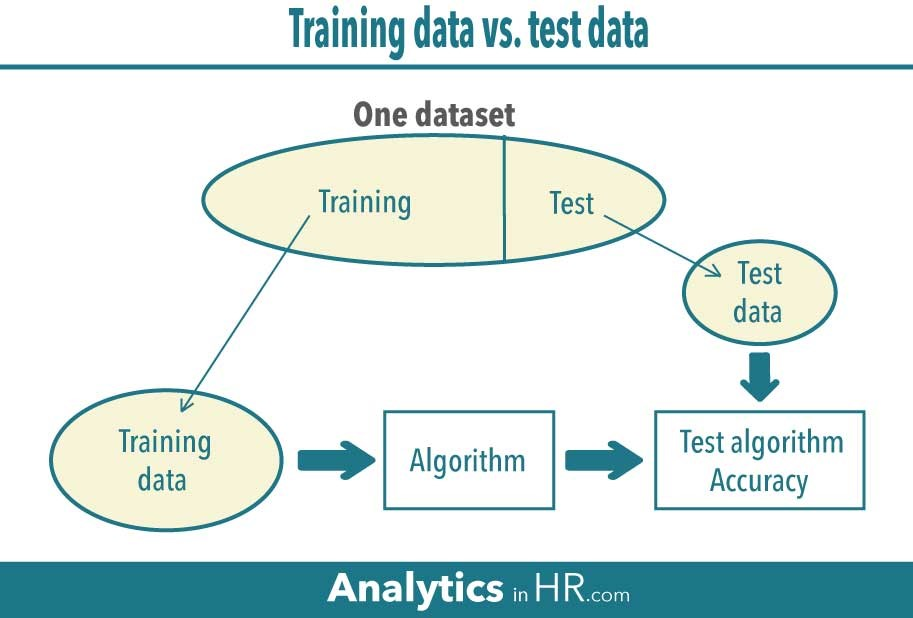

In [35]:
Image("images/traintest.jpg", width=600)


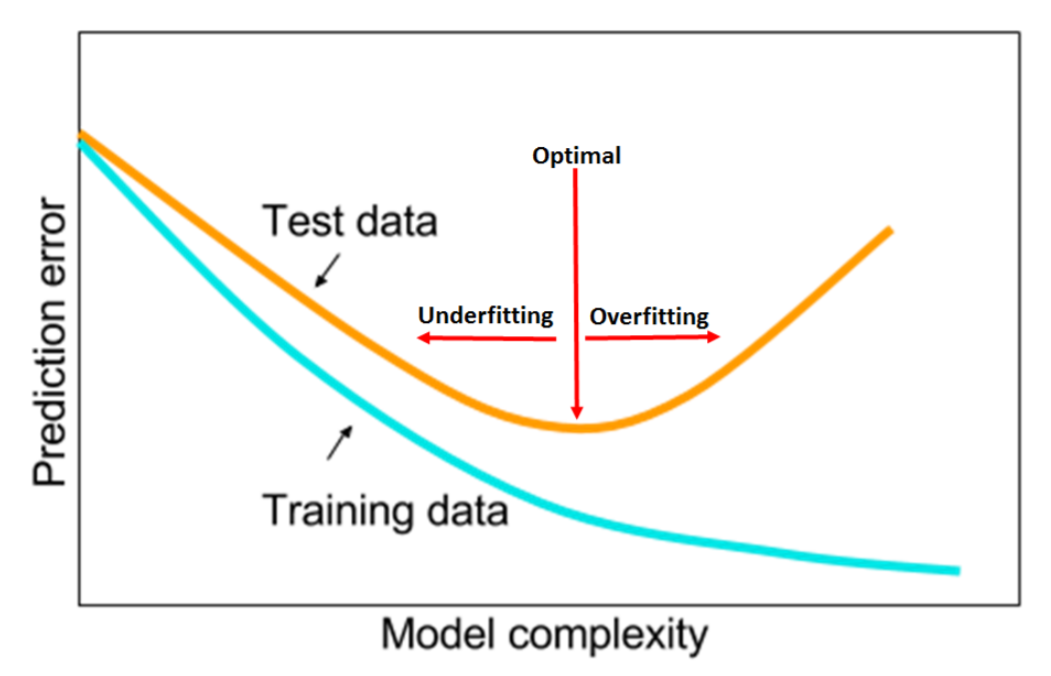

In [36]:
Image("images/testoverfit.png", width=600)


## Как мерить качество?

Слова "лучше работает" - очень субьективны, не очень понятно, что они означают.

Мы пока что только смотрим на картинки и говорим, что стало лучше или хуже. Можно ли как-то объективно и количественно измерить, насколько хорошо обучился классификатор?

К счастью, да. Для этого существуют `метрики классификации`, и самая простая метрика - $accuracy$ или доля правльных ответов. Доля правильных ответов - отношение объектов, которые классифицировались правильно, ко всем объектам.

Пусть нам даны метки $y_{real}$ и результат нашего алгоритма $y_{pred}$. 

In [37]:
from sklearn.metrics import accuracy_score

y_real = np.array([0, 1, 0, 0, 1, 1, 1, 1])
y_pred = np.array([0, 1, 1, 0, 1, 1, 0, 0])

accuracy_score(y_real, y_pred)


0.625

In [38]:
from sklearn.neighbors import KNeighborsClassifier as KNC

clf_dtc = KNC(n_neighbors=3).fit(X_clf, y_clf)
accuracy_score(y_clf, clf_dtc.predict(X_clf))


0.9475

# Теорема Байеса

![](images/bayes_theorem.webp)

Помогает перейти от событий, вероятность которых нам неизвестна\неясна к событиям вероятности которых мы можем посчитать. 

### Пример
Честно украден [у Александра Дьяконова](https://alexanderdyakonov.wordpress.com/2015/10/12/%D1%84%D0%BE%D1%80%D0%BC%D1%83%D0%BB%D0%B0-%D0%B1%D0%B0%D0%B9%D0%B5%D1%81%D0%B0/)

```
Тест на болезнь «зеленуху» имеет вероятность ошибки 0.1 (как позитивной, так и негативной), зеленухой болеет 10% населения. Какая вероятность того, что человек болен зеленухой, если у него позитивный результат теста?
```

![](images/dyakonov_bayes.png)

Получаем, что искомая вероятность: (0.9 * 0.1)/(0.9 * 0.1 + 0.1 * 0.9) = 0.5.

Это удивительно. Смотрите, мы взяли прибор с очень неплохой погрешностью… всё-таки в 9 из 10 случаях он не ошибается. А получилось, что он работает как подбрасывание монеты. И верить ему совсем(!) нельзя.

`Вопрос:` Где я вас обманул?

Text(0, 0.5, 'P(болен|+)')

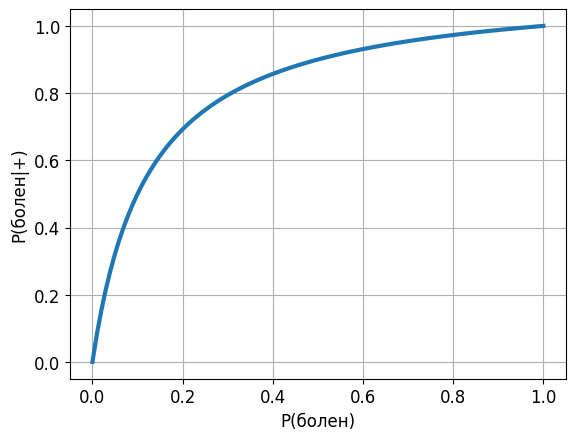

In [ ]:
def get_probability(ill_prob, error_prob):
    return (( 1 - error_prob) * ill_prob) / ((1 - error_prob)*ill_prob + error_prob * (1 - ill_prob))

ill_probs = np.linspace(0,1,101)
ax = plt.gca()
ax.plot(ill_probs, [get_probability(x, .1) for x in ill_probs], lw=3)
ax.grid()
ax.set_xlabel('P(болен)')
ax.set_ylabel('P(болен|+)')

`Ответ`: мы не тестируем всех подряд. Мы обычно тестируем тех, у кого и так есть симптомы болезни, т.е. вероятность P(болен) существенно выше, чем средние по популяции 10%. Поэтому и точности теста хватает, чтобы быть лучше, чем бросок монетки. Только что мы доказали бессмысленность массовых ковид-тестов бессимптомных людей:)

Давайте проверим, что теорема работает на практике. Правда ли бывает так, что `P(A|B) != P(B|A)`, но по теореме Байеса всё пересчитывается?

In [39]:
def get_from_black_box():
    return random.random() > 0.9

def get_from_white_box():
    return random.random() > 0.1

def get_dataset(num):
    res = []
    for _ in range(num):
        if random.random() > 0.5:
            res.append({
                'box': 'black',
                'value': get_from_black_box()
            })
        else:
            res.append({
                'box': 'white',
                'value': get_from_white_box()
            })
    return pd.DataFrame().from_records(res)

In [40]:
random.seed(1234)
df = get_dataset(100)
df.head()

,box,value
0,black,False
1,white,True
2,black,False
3,black,False
4,black,False


In [41]:
true_values = df[df['value']]
black_box_values = df[df['box']=='black']

p_true_if_black = black_box_values['value'].sum() / len(black_box_values)
p_black_if_true = sum(true_values['box'] == 'black') / len(true_values)
p_black = sum(df['box']=='black') / len(df)
p_true = sum(df['value']) / len(df)

p_bayes = round(p_true_if_black * p_black / p_true, 3)
print(f'P(True | from_black_box) = ', round(p_true_if_black, 3))
print(f'P(from_black_box | True) = ', round(p_black_if_true, 3))
print(f'\nP(True | from_black_box) * P(from_black_box)\n--------------------------------------------- = {p_bayes} = P(from_black_box | True)\n                 P(True)')

P(True | from_black_box) =  0.089
P(from_black_box | True) =  0.073

P(True | from_black_box) * P(from_black_box)
--------------------------------------------- = 0.073 = P(from_black_box | True)
                 P(True)


# Наивный байесовский классификатор.

Пусть $y_{test}$ - неизвестный класс объекта $x_{test}$ из тестовой выборки, который мы хотим найти. $c \in \{0,1\}$ - значение класса.
Давайте распишем вероятности попадания в определенный класс по теореме Байеса:

$$P(y_{test}=c|x_{test})=P(y_{test}=c|f_1^{test}, \ldots, f_m^{test}) = \frac{P(f_1^{test}, \ldots, f_m^{test}|y_{test}=c)P(y_{test}=c)
}{P(f_1^{test}, \ldots, f_m^{test})}$$

Заметим, что $P(f_1^{test}, \ldots, f_m^{test})$ не зависит от класса, который мы выбираем, поэтому мы можем перейти к другой задаче, так как нас при классификации нас часто волнует не конкретная вероятность, а знание о том, для какого класса вероятность максимальная:

$$P(y_{test}=c|f_1^{test}, \ldots, f_m^{test}) \sim P(f_1^{test}, \ldots, f_m^{test}|y_{test}=c)P(y_{test}=c)
$$

$$y_{test} = argmax_{c}P(f_1^{test}, \ldots, f_m^{test}|y_{test}=c)P(y_{test}=c)$$

Сделаем **сильное** предположение, что все признаки - независимы внутри одного класса.

$$P(f_1^{test}, \ldots, f_m^{test}|y_{test}=c) = \prod_{j=1}^{m}P(f_j^{test}|y_{test}=c)$$

Мы хотим искать существующий класс по известным величинам которые мы можем у объекта померить и которые есть у нас в датасете. Можем ли мы как-то найти вероятности выше?

## Дискретный случай

Пусть признаки $f$ - у нас упорядоченные категориальные. Например оценка: 2,3,4,5.

Тогда априорная вероятность признака:

$$P(f_j=a) = \frac{\sum_{i=1}^{n}\mathcal{I}(f_j^{(i)} = a)}{n}$$

$a$ - значение признака. $\mathcal{I}$ - индикаторная функция. $j$ - номер признака. $f_j^{(i)}$ - значение $j$-ого признака у $i$-ого объекта. $n$ - количество объектов.

А апостериорная вероятность:

$$P(f_j=a|y=c) = \frac{\sum_{i=1}^{n}\mathcal{I}(f_j^{(i)} = a \& y_i=c)}{\sum_{i=1}^{n}\mathcal{I}(y_i=c)}$$

В числителе все объекты $i$ такие, что $f_j^{(i)} = a$ **и** $y_i=c$.В знаменателе количество объектов в обучающей выборке, у которых $y_i = c$.

И самое простое:
$$P(y=c) = \frac{\sum_{i=1}^{n}\mathcal{I}(y_i=c)}{n}$$

Тут возникает опасная проблема: какая-то вероятность может уйти в 0. Тогда все перемножение занулится - для этого добавим ко всем вероятностям некий коэффициент $\alpha$:

$$\hat{P}(f_j=a|y=c) = P(f_j=a|y=c) + \alpha$$

Формально это уже будут не вероятности, но на решение задачи максимизации это не повлияет, зато гарантирует корректные численные преобразования.

Итого получили:
    $$y_{test} = argmax_{c}P(y_{test}=c)\prod_{j=1}^{m}\hat{P}(f_j|y_{test}=c)$$

Так как нас интересует argmax, мы можем рассмотреть вместо произведения его логарифм. 

Логарифм - функция монотонная, т.е. результат взятия argmax не изменится, а числа у нас все больше ноля. Но, как известно, логарифм произведения равен сумме логарифмов сомножителей. 

Перейдя от перемножения множества мелких чисел к их суммированию мы *существенно* уменьшаем численные погрешности в результатах операций с плавающей точкой.

$$y_{test} = argmax_{c}\ln{P(y_{test}=c)} + \sum_{j=1}^{m}\ln{\hat{P}(f_j|y_{test}=c)}$$

Или если все-все подставить

$$y_{test} = argmax_{c}\ln{\frac{\sum_{i=1}^{n}\mathcal{I}(y_i=c)}{n}} + \sum_{j=1}^{m}\ln{\Big(\frac{\sum_{i=1}^{n}\mathcal{I}(f_j^{(i)} = a|y_i=c)}{\sum_{i=1}^{n}\mathcal{I}(y_i=c)} + \alpha\Big)}$$

Мы получили [sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

## Непрерывный случай

Так как мы не можем сейчас считать индексы - они все могут быть разные, нам надо предположить какая вероятность может быть у признака в некоторой точке.

Пусть

$$P(f_j = x) = \rho_{\mathcal{F}}(x),\quad \mathcal{F} \sim \mathcal{N}(\mu(f_j), \sigma^2(f_j)))$$

$$P(f_j = x| y_i = c) = \rho_{\mathcal{F}}(x),\quad \mathcal{F} \sim \mathcal{N}(\mu(f_j), \sigma^2(f_j)|y_i=c))$$

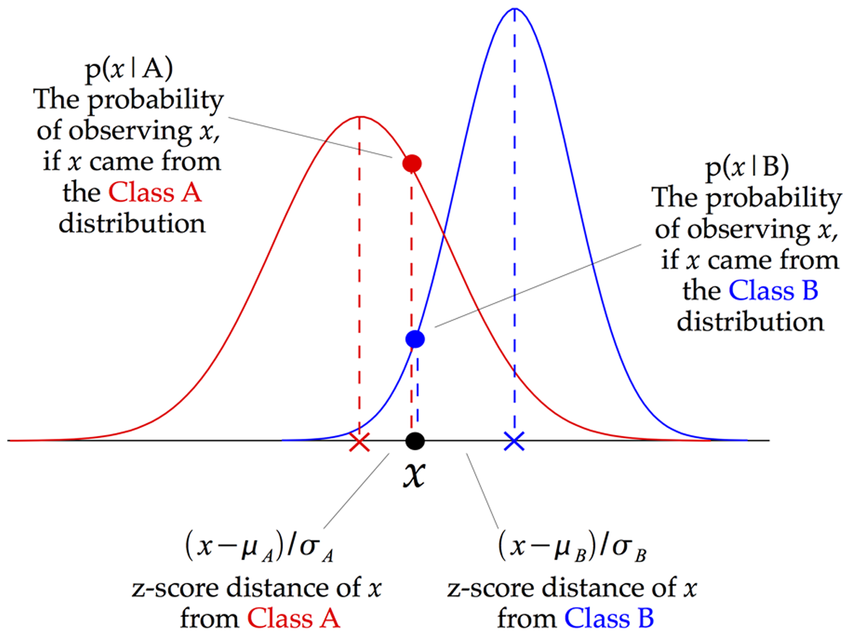

In [43]:
Image("images/bayesdist.png")

## Вопросы:
* Можно ли сделать регрессию на наивном Байесе?

# Резюме
* Узнали, что такое задача Машинного обучения.
* Поигрались с разными классификаторами и регрессорами
* Гиперпараметры и параметры
* Переобучение и недообучение

## Источники материалов:
* [mlcourse.ai](https://github.com/Yorko/mlcourse.ai) - курс Машинного обучения с OpenDataScience
* [AI Seminars](https://github.com/AICommunityInno/Seminars) - семинары по Машинному обучению в Иннополисе
* [HSE-ML course](https://github.com/esokolov/ml-course-hse) - курс Машинного обучения ФКН ВШЭ